# Bayesian Cross Sectional Models

This notebook investigates the fit and parameter estimates of Bayesian models. We try the following three distributions:
- Pareto
- Weibull
- Generalised Pareto

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import dill
import os
import scipy

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Self made modules
from thesis_tools.utils.data import *
from thesis_tools.utils.model_fitting import *
from thesis_tools.utils.latex import *
from thesis_tools.statistical_tests.tests import *
from thesis_tools.models.bayesian_univariate_cross_sectional import *
from thesis_tools.models.bayesian_multivariate_cross_sectional import *

## Estimation

In [4]:
df = read_panel_data(observations_threshold=0)
len(df)

406

In [5]:
groups = df['group'].unique()
for group in groups:
    for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
        train_or_retrieve_regularised_cross_sectional_model(
            panel_df=df,
            group=group,
            model_type=model_type,
            retrain_if_saved=False
        )

## Evaluation

### Prior Predictive Checks

### Fit

We evaluate the fit similarly to the way we evaluated the fit for frequentist models:
- Kolmogorov-Smirnof Test
- Anderson-Darling Test
- Cramer- von Mises Test

In [6]:
path = "../../Stored_Results/bayesian_cross_sectional_regularised/test_df.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        test_df = dill.load(f)
else:
    test_dict = {}
    for group in groups:
        for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
            print(f"Testing {group} using {model_type} distribution")
            model = train_or_retrieve_regularised_cross_sectional_model(
                panel_df=df,
                group=group,
                model_type=model_type,
                retrain_if_saved=False
            )
            post_pred_df = model.posterior_predictive()
            years = df[df['group'] == group]['year'].unique()
            for year in years:
                post_pred = post_pred_df[f'y_{year}']
                true_data = np.array(df[(df['group'] == group) & (df['year'] == year)]['net_worth'].values[0])
                ks_stat, ks_pval = Kolmogorov_Smirnov_two_sample_test(data1=post_pred, data2=true_data)
                _, cm_stat = Anderson_Darling_statistic(data_1=post_pred, data_2=true_data, weight_function='Cramer-von Mises')
                _, ad_stat = Anderson_Darling_statistic(data_1=post_pred, data_2=true_data, weight_function='Anderson-Darling')
                test_dict[(year, group, model_type)] = {'KS_stat': ks_stat, 'KS_pval': ks_pval, 'CM_stat': cm_stat, 'AD_stat': ad_stat}
    test_df = pd.DataFrame(test_dict).T
    test_df.index.names = ['year', 'group', 'model_type']
    with open(path, 'wb') as f:
        dill.dump(test_df, f)

In [7]:
test_df

,,,KS_stat,KS_pval,CM_stat,AD_stat
year,group,model_type,,,,
1999,Alps,Pareto,0.629900,0.740326,0.134844,1.348439e+08
2000,Alps,Pareto,0.556800,0.886511,0.058434,5.843441e+07
2001,Alps,Pareto,0.351643,0.281258,0.038419,3.841890e+07
2002,Alps,Pareto,0.472500,0.094554,0.010469,1.046892e+07
2003,Alps,Pareto,0.244643,0.713778,0.019202,1.920216e+07
...,...,...,...,...,...,...
2018,U.S.,GeneralisedPareto,0.082230,0.001051,0.013136,1.941708e+05
2019,U.S.,GeneralisedPareto,0.064014,0.017525,0.009463,9.687972e+04
2020,U.S.,GeneralisedPareto,0.058702,0.035349,0.005702,3.194284e+05


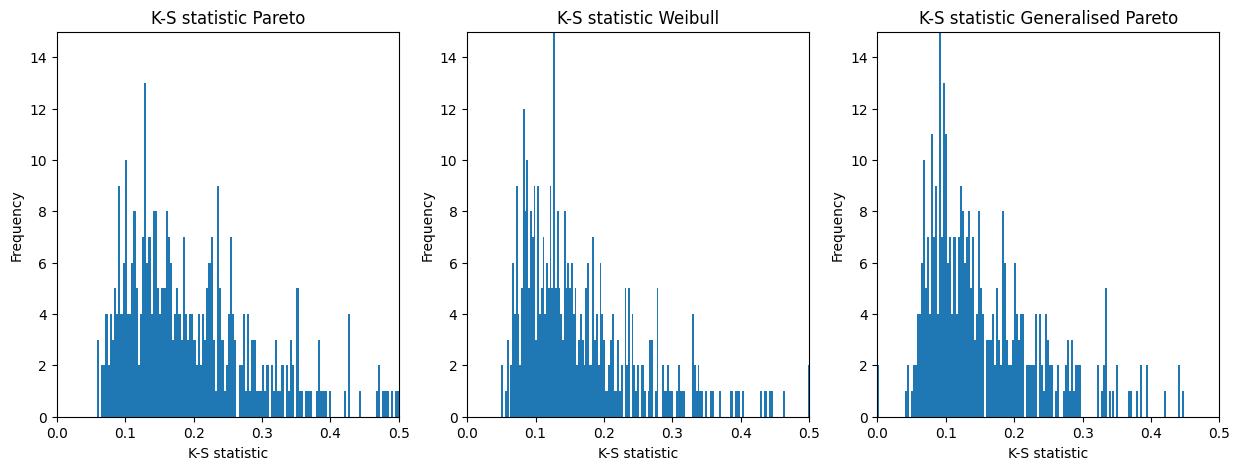

In [8]:
# Plot the K-S stats for the 3 distributions next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 0.5
y_lb, y_ub = 0, 15
n_bins = 300
ax[0].hist(test_df.xs('Pareto', level='model_type')['KS_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('K-S statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('K-S statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['KS_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('K-S statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('K-S statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['KS_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('K-S statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('K-S statistic Generalised Pareto')
plt.show()


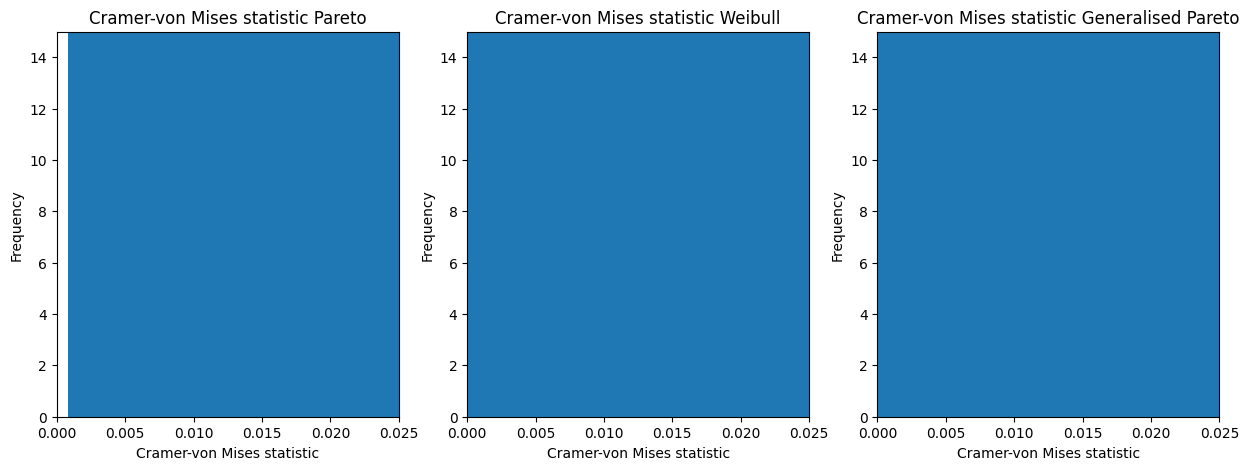

In [9]:
# Do the same for the Cramer-von Mises statistic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 0.025
y_lb, y_ub = 0, 15
n_bins = 50
ax[0].hist(test_df.xs('Pareto', level='model_type')['CM_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('Cramer-von Mises statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Cramer-von Mises statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['CM_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('Cramer-von Mises statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Cramer-von Mises statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['CM_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('Cramer-von Mises statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Cramer-von Mises statistic Generalised Pareto')
plt.show()

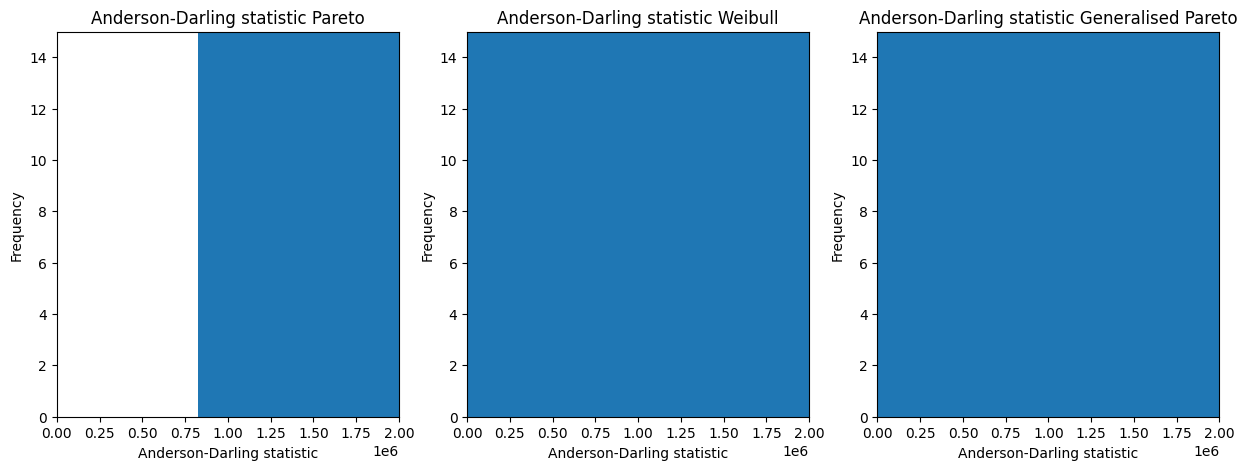

In [10]:
# Do the same for the Anderson-Darling statistic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 2e6
y_lb, y_ub = 0, 15
n_bins = 100
ax[0].hist(test_df.xs('Pareto', level='model_type')['AD_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('Anderson-Darling statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Anderson-Darling statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['AD_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('Anderson-Darling statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Anderson-Darling statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['AD_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('Anderson-Darling statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Anderson-Darling statistic Generalised Pareto')
plt.show()

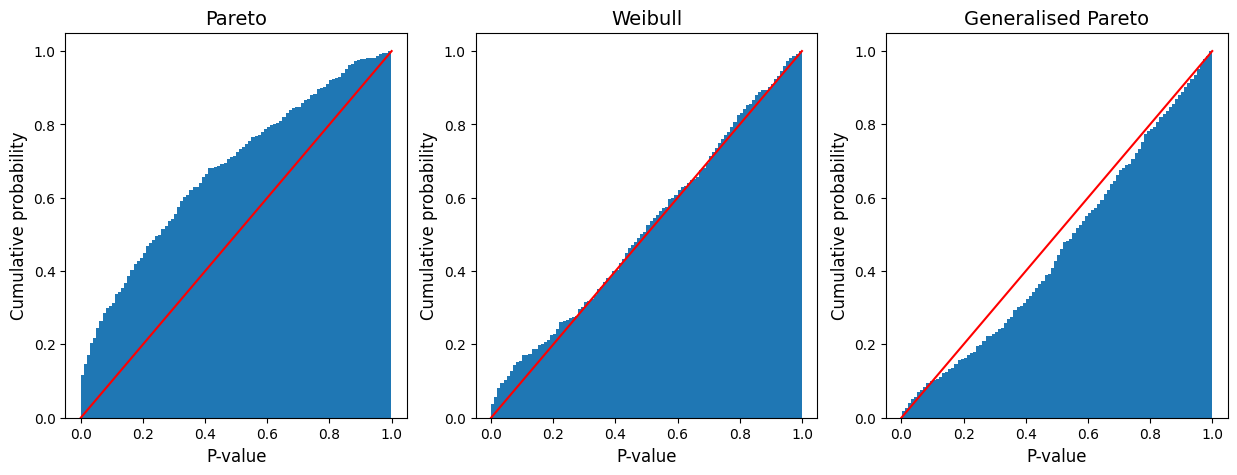

In [11]:
# Compare how often the null hypothesis is rejected for the 3 distributions
# Find the empirical distribution of the p-values for the 3 distributions
pareto_pvals = test_df.xs('Pareto', level='model_type')['KS_pval']
weibull_pvals = test_df.xs('Weibull', level='model_type')['KS_pval']
generalised_pareto_pvals = test_df.xs('GeneralisedPareto', level='model_type')['KS_pval']

# Plot the empirical cumulative distribution function of the p-values
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 100
ax[0].hist(pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color='red')
ax[0].set_xlabel('P-value', fontsize=12)
ax[0].set_ylabel('Cumulative probability', fontsize=12)
ax[0].set_title('Pareto', fontsize=14)
ax[1].hist(weibull_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[1].plot(x, x, color='red')
ax[1].set_xlabel('P-value', fontsize=12)
ax[1].set_ylabel('Cumulative probability', fontsize=12)
ax[1].set_title('Weibull', fontsize=14)
ax[2].hist(generalised_pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[2].plot(x, x, color='red')
ax[2].set_xlabel('P-value', fontsize=12)
ax[2].set_ylabel('Cumulative probability', fontsize=12)
ax[2].set_title('Generalised Pareto', fontsize=14)
plt.show()



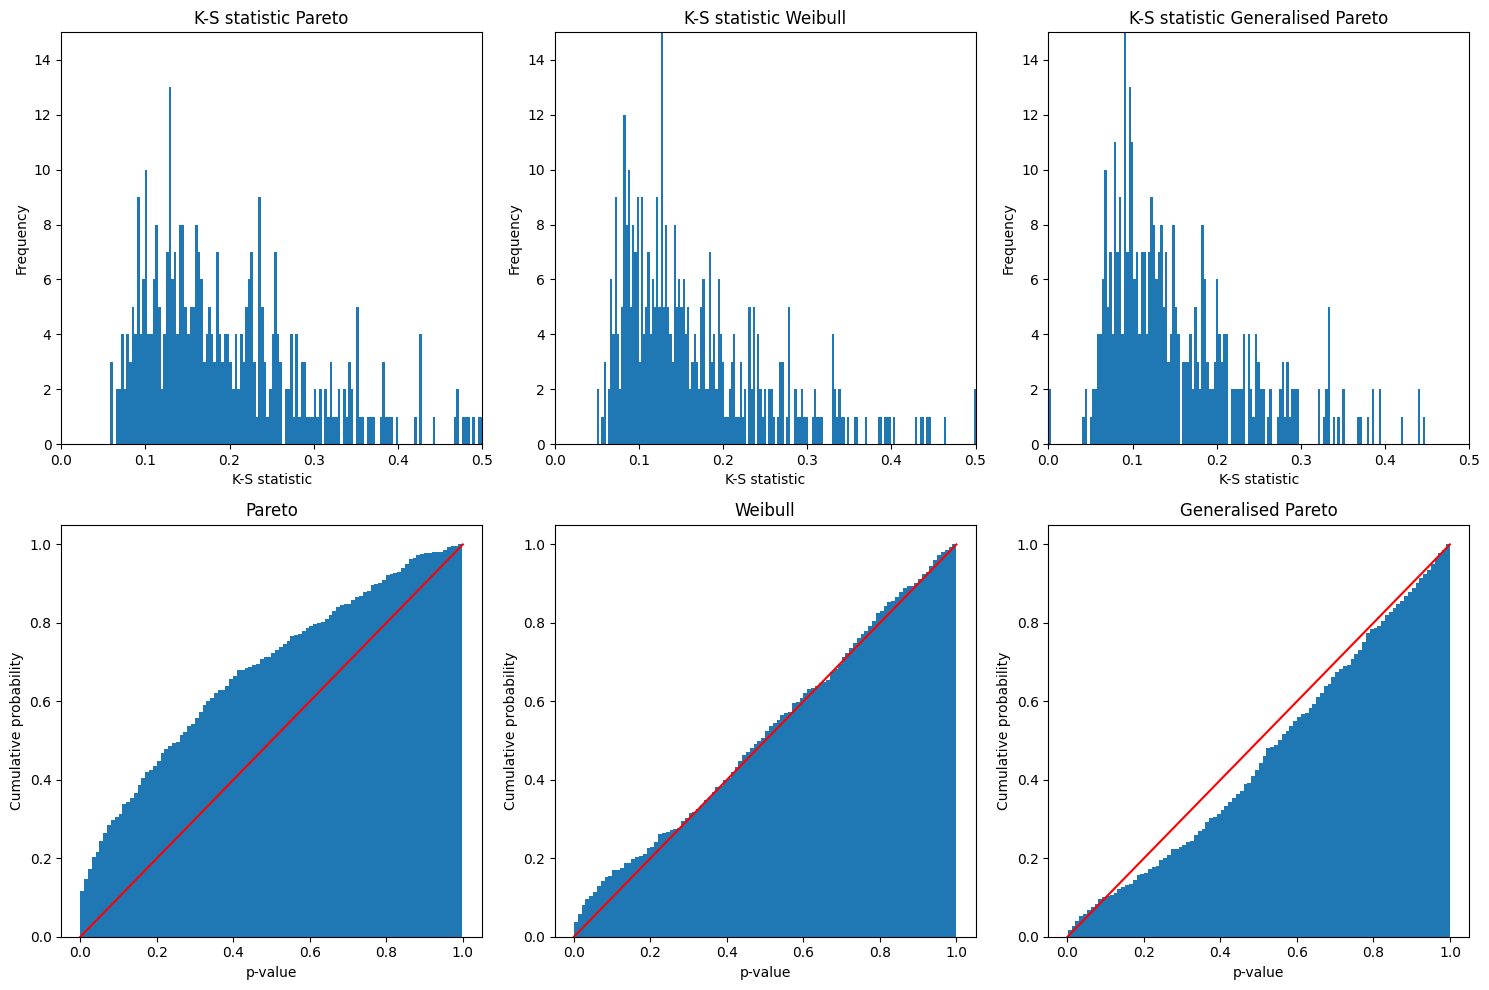

In [12]:
# Set up a 2x3 grid for the subplots
fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the height to accommodate both rows

# Define common plot settings
x_lb, x_ub = 0.00, 0.5
y_lb, y_ub = 0, 15
n_bins_stat = 300
n_bins_pval = 100
x_pval = np.linspace(0, 1, 100)

# Plot the K-S statistics
ax[0, 0].hist(test_df.xs('Pareto', level='model_type')['KS_stat'], bins=n_bins_stat)
ax[0, 0].set_xlim(x_lb, x_ub)
ax[0, 0].set_ylim(y_lb, y_ub)
ax[0, 0].set_xlabel('K-S statistic')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('K-S statistic Pareto')

ax[0, 1].hist(test_df.xs('Weibull', level='model_type')['KS_stat'], bins=n_bins_stat)
ax[0, 1].set_xlim(x_lb, x_ub)
ax[0, 1].set_ylim(y_lb, y_ub)
ax[0, 1].set_xlabel('K-S statistic')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('K-S statistic Weibull')

ax[0, 2].hist(test_df.xs('GeneralisedPareto', level='model_type')['KS_stat'], bins=n_bins_stat)
ax[0, 2].set_xlim(x_lb, x_ub)
ax[0, 2].set_ylim(y_lb, y_ub)
ax[0, 2].set_xlabel('K-S statistic')
ax[0, 2].set_ylabel('Frequency')
ax[0, 2].set_title('K-S statistic Generalised Pareto')

# Plot the empirical cumulative distribution function of the p-values
pareto_pvals = test_df.xs('Pareto', level='model_type')['KS_pval']
weibull_pvals = test_df.xs('Weibull', level='model_type')['KS_pval']
generalised_pareto_pvals = test_df.xs('GeneralisedPareto', level='model_type')['KS_pval']

ax[1, 0].hist(pareto_pvals, bins=n_bins_pval, cumulative=True, density=True)
ax[1, 0].plot(x_pval, x_pval, color='red')
ax[1, 0].set_xlabel('p-value')
ax[1, 0].set_ylabel('Cumulative probability')
ax[1, 0].set_title('Pareto')

ax[1, 1].hist(weibull_pvals, bins=n_bins_pval, cumulative=True, density=True)
ax[1, 1].plot(x_pval, x_pval, color='red')
ax[1, 1].set_xlabel('p-value')
ax[1, 1].set_ylabel('Cumulative probability')
ax[1, 1].set_title('Weibull')

ax[1, 2].hist(generalised_pareto_pvals, bins=n_bins_pval, cumulative=True, density=True)
ax[1, 2].plot(x_pval, x_pval, color='red')
ax[1, 2].set_xlabel('p-value')
ax[1, 2].set_ylabel('Cumulative probability')
ax[1, 2].set_title('Generalised Pareto')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Mean wealth prediction

In [13]:
path = "../../Stored_Results/bayesian_cross_sectional_regularised/mean_wealth_df.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        mean_wealth_df = dill.load(f)
else:
    mean_wealth = {}
    for group in groups:
        print(f"Calculating mean wealth for {group}")
        for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
            model = train_or_retrieve_regularised_cross_sectional_model(panel_df=df, group=group, model_type=model_type, retrain_if_saved=False)
            post_pred_df = model.posterior_predictive()
            years = df[df['group'] == group]['year'].unique()
            for year in years:
                post_pred = post_pred_df[f'y_{year}']
                mean_data = np.array(df[(df['year'] == year) & (df['group'] == group)]['net_worth'].iloc[0]).mean()
                mean_wealth[(year, group, model_type)] = {
                    'mean_data': mean_data,
                    'mean_model': post_pred.mean(),
                    'resid': mean_data - post_pred.mean(),
                    'abs_resid': np.abs(mean_data - post_pred.mean()),
                    'squared_resid': (mean_data - post_pred.mean())**2
                }
    mean_wealth_df = pd.DataFrame(mean_wealth).T
    mean_wealth_df.index.names = ['year', 'group', 'model_type']
    with open(path, 'wb') as f:
        dill.dump(mean_wealth_df, f)

In [14]:
mean_wealth_df

,,,mean_data,mean_model,resid,abs_resid,squared_resid
year,group,model_type,,,,,
1999,Alps,Pareto,2.900000,17.837978,-14.937978,14.937978,223.143173
2000,Alps,Pareto,1.900000,16.704132,-14.804132,14.804132,219.162317
2001,Alps,Pareto,4.042857,31.327285,-27.284428,27.284428,744.439985
2002,Alps,Pareto,3.950000,25.538523,-21.588523,21.588523,466.064317
2003,Alps,Pareto,2.428571,30.648143,-28.219572,28.219572,796.344233
...,...,...,...,...,...,...,...
2018,U.S.,GeneralisedPareto,5.287884,5.408475,-0.120591,0.120591,0.014542
2019,U.S.,GeneralisedPareto,5.125206,5.570935,-0.445729,0.445729,0.198675
2020,U.S.,GeneralisedPareto,4.794634,4.497501,0.297133,0.297133,0.088288


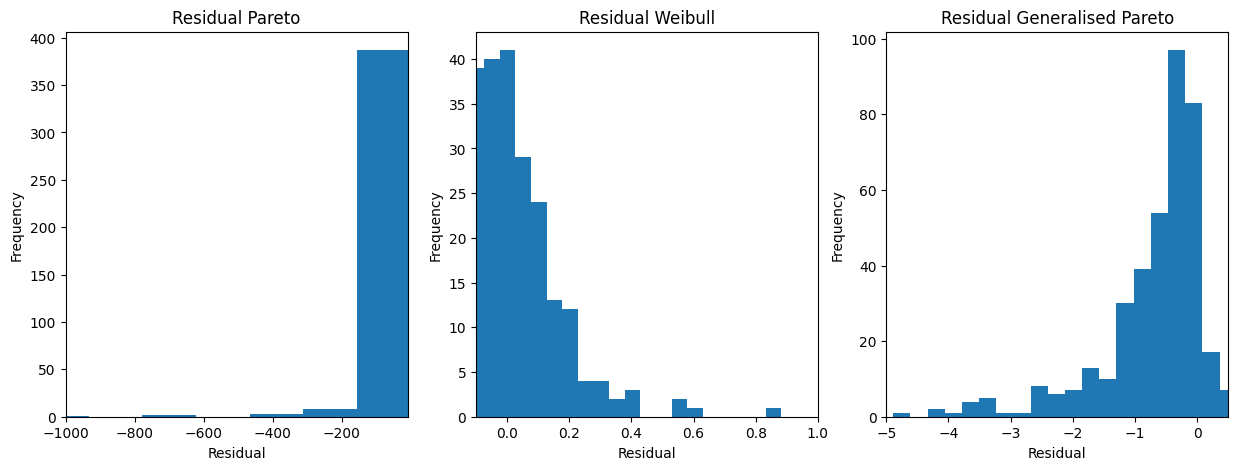

In [15]:
# Plot the residuals for the 3 distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 100
ax[0].hist(mean_wealth_df.xs('Pareto', level='model_type')['resid'], bins=n_bins)
ax[0].set_xlim(-1000, -10)
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Residual Pareto')
ax[1].hist(mean_wealth_df.xs('Weibull', level='model_type')['resid'], bins=n_bins)
ax[1].set_xlim(-0.1, 1.0)
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Residual Weibull')
ax[2].hist(mean_wealth_df.xs('GeneralisedPareto', level='model_type')['resid'], bins=n_bins)
ax[2].set_xlim(-5, 0.5)
ax[2].set_xlabel('Residual')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Residual Generalised Pareto')
plt.show()

In [16]:
# find the average absolute residuals by country/distribution:
without_pareto = mean_wealth_df[mean_wealth_df.index.get_level_values('model_type') != 'Pareto']
grouped_mean_wealth = without_pareto.groupby(['group', 'model_type']).mean()

In [17]:
unregularised_path = "../../Stored_Results/bayesian_cross_sectional/mean_wealth_df.pkl"
if os.path.exists(unregularised_path):
    with open(unregularised_path, 'rb') as f:
        unregularised_mean_wealth_df = dill.load(f)

In [18]:
unregularised_mean_wealth_df

mean_data  mean_model       resid  \
year group         model_type                                             
2013 Alps          Pareto              3.657143  494.873963 -491.216820   
                   Weibull             3.657143    3.639172    0.017971   
                   GeneralisedPareto   3.657143    5.395124   -1.737981   
     Asian Islands Pareto              2.708065    7.591789   -4.883725   
                   Weibull             2.708065    2.714133   -0.006069   
...                                         ...         ...         ...   
2001 U.S.          Weibull             3.818681    3.516005    0.302676   
                   GeneralisedPareto   3.818681    4.778176   -0.959495   
2002 U.S.          Pareto              3.571591    7.336096   -3.764505   
                   Weibull             3.571591    3.230864    0.340727   
                   GeneralisedPareto   3.571591    4.744983   -1.173392   

                                       abs_resid  squared_resid  
year group         model_type                                    
2013 Alps          Pareto             491.216820  241293.964132  
                   Weibull              0.017971       0.000323  
                   GeneralisedPareto    1.737981       3.020577  
     Asian Islands Pareto               4.883725      23.850768  
                   Weibull              0.006069       0.000037  
...                                          ...            ...  
2001 U.S.          Weibull              0.302676       0.091613  
                   GeneralisedPareto    0.959495       0.920631  
2002 U.S.          Pareto               3.764505      14.171498  
                   Weibull              0.340727       0.116095  
                   GeneralisedPareto    1.173392       1.376848  

[750 rows x 5 columns]

In [19]:
unregularised_mean_wealth_gpd = unregularised_mean_wealth_df.xs('GeneralisedPareto', level='model_type')['abs_resid']
unregularised_mean_wealth_weibull = unregularised_mean_wealth_df.xs('Weibull', level='model_type')['abs_resid']
mean_wealth_gpd = mean_wealth_df.xs('GeneralisedPareto', level='model_type')['abs_resid']
mean_wealth_weibull = mean_wealth_df.xs('Weibull', level='model_type')['abs_resid']

In [20]:
unregularised_gpd_mean_summary = unregularised_mean_wealth_gpd.describe()
unregularised_weibull_mean_summary = unregularised_mean_wealth_weibull.describe()
gpd_mean_summary = mean_wealth_gpd.describe()
weibull_mean_summary = mean_wealth_weibull.describe()

In [21]:
dataframe_to_latex_table(
    pd.DataFrame([
        unregularised_gpd_mean_summary,
        unregularised_weibull_mean_summary,
        gpd_mean_summary, 
        weibull_mean_summary
        ]).T.round(2),
    caption='Mean absolute residuals by distribution',
    label='tab:mean_abs_residuals',
    n_decimals=2)

\begin{table}
\caption{Mean absolute residuals by distribution}
\label{tab:mean_abs_residuals}
\begin{tabular}{lrrrr}
\toprule
 & abs\_resid & abs\_resid & abs\_resid & abs\_resid \\
\midrule
count & 250.00 & 250.00 & 406.00 & 406.00 \\
mean & 1.68 & 0.13 & 1.08 & 0.37 \\
std & 3.37 & 0.23 & 2.04 & 0.54 \\
min & 0.04 & 0.00 & 0.00 & 0.00 \\
25% & 0.69 & 0.02 & 0.21 & 0.07 \\
50% & 0.96 & 0.06 & 0.47 & 0.16 \\
75% & 1.43 & 0.16 & 1.11 & 0.41 \\
max & 30.10 & 2.16 & 25.06 & 3.45 \\
\bottomrule
\end{tabular}
\end{table}



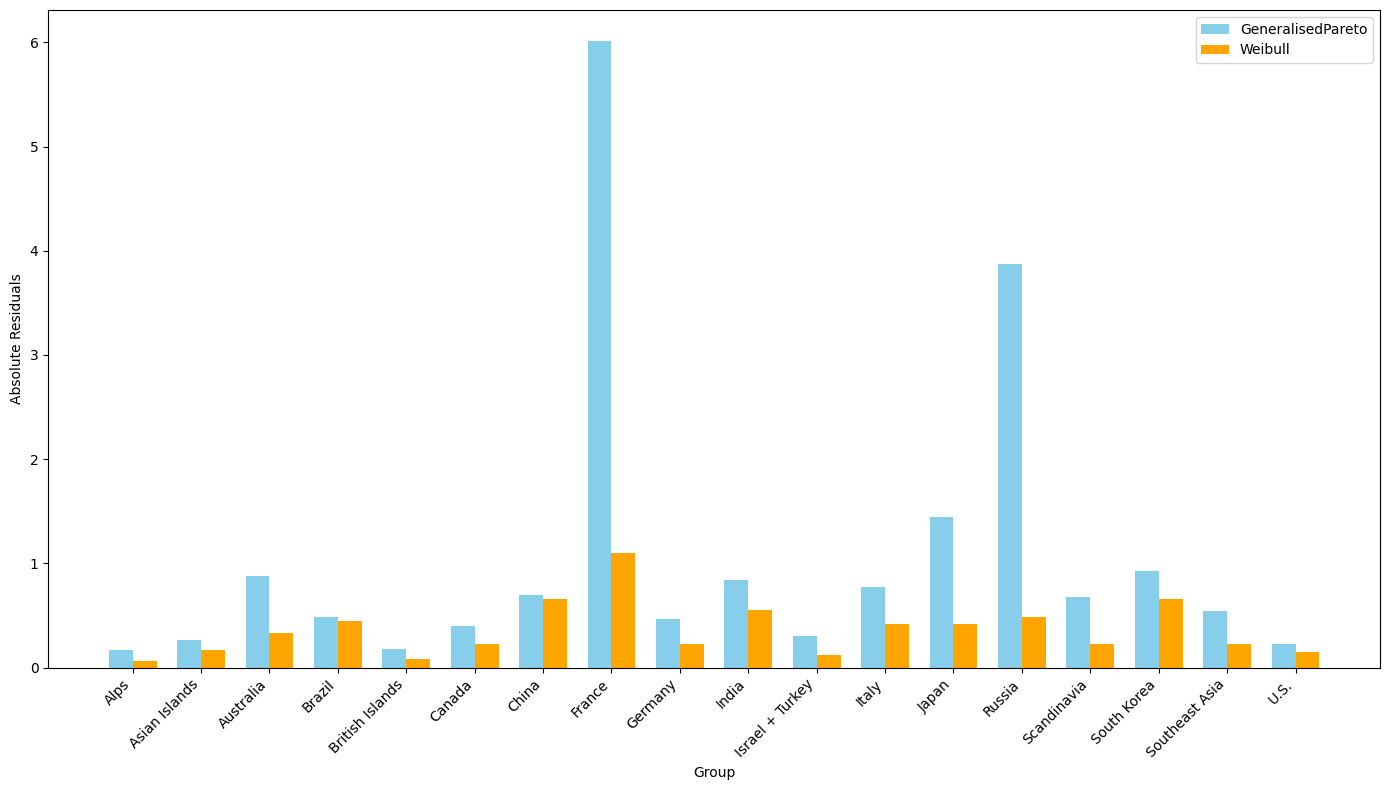

In [22]:
# Plotting the bar plot for abs_resid column
fig, ax = plt.subplots(figsize=(14, 8))

# Extract data for plotting
groups = grouped_mean_wealth.index.get_level_values('group').unique()
x = np.arange(len(groups))  # the label locations
width = 0.35  # the width of the bars

# Data for bars
generalised_pareto_resid = grouped_mean_wealth.xs('GeneralisedPareto', level='model_type')['abs_resid']
weibull_resid = grouped_mean_wealth.xs('Weibull', level='model_type')['abs_resid']

# Plot bars
rects1 = ax.bar(x - width/2, generalised_pareto_resid, width, label='GeneralisedPareto', color='skyblue')
rects2 = ax.bar(x + width/2, weibull_resid, width, label='Weibull', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Group')
ax.set_ylabel('Absolute Residuals')
# ax.set_title('Absolute Residuals by Group and Model Type')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha="right")
ax.legend()

fig.tight_layout()

# Display the plot
plt.show()

In [23]:
grouped_by_year_mean_wealth = without_pareto.groupby(['year', 'model_type']).median()

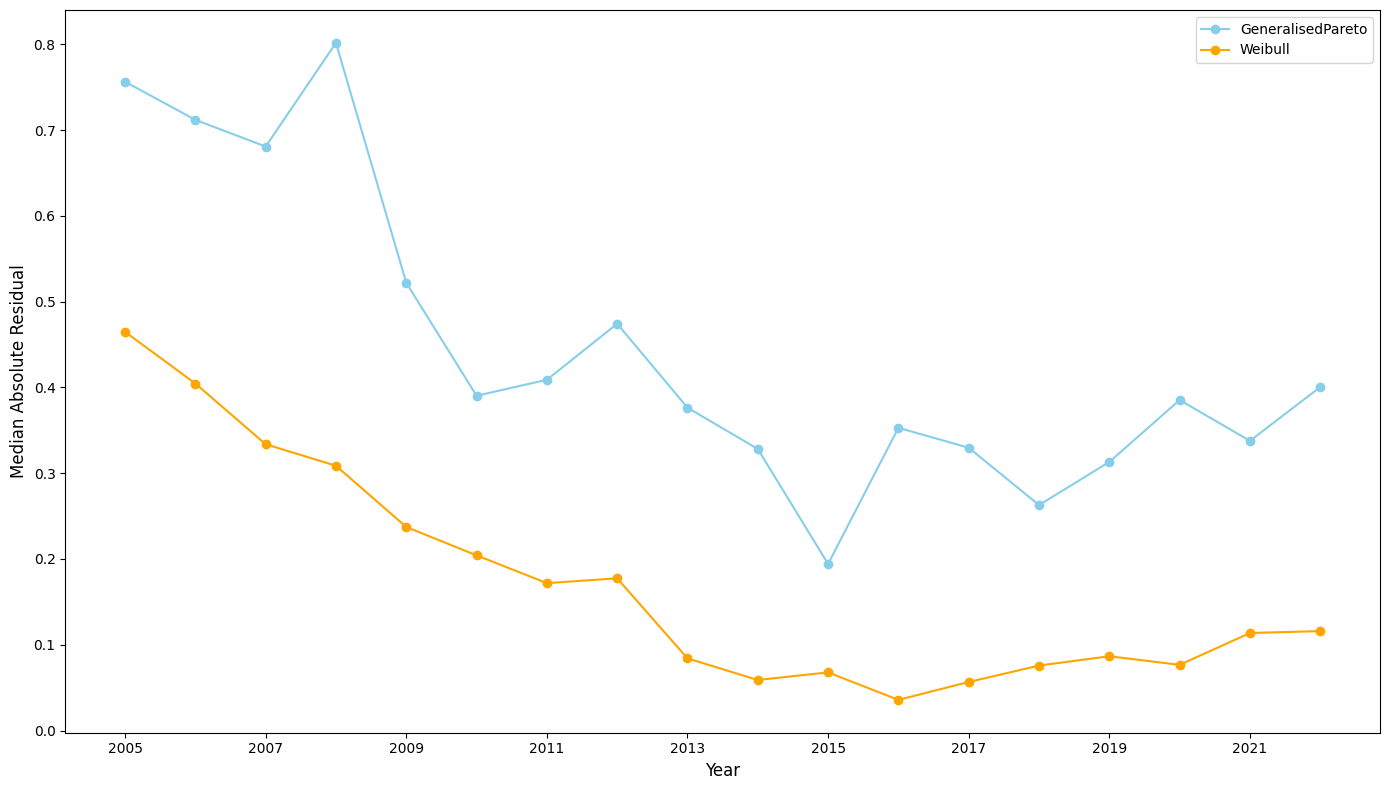

In [25]:
# Plotting the line plot for abs_resid column
fig, ax = plt.subplots(figsize=(14, 8))

# Extract data for plotting
years = grouped_by_year_mean_wealth.index.get_level_values('year').unique()
# only from 2005 onwards
years = years[years >= 2005]

# Data for lines
generalised_pareto_resid = grouped_by_year_mean_wealth.xs('GeneralisedPareto', level='model_type')['abs_resid']
weibull_resid = grouped_by_year_mean_wealth.xs('Weibull', level='model_type')['abs_resid']
# cut off the years before 2005
generalised_pareto_resid = generalised_pareto_resid[generalised_pareto_resid.index.get_level_values('year') >= 2005]
weibull_resid = weibull_resid[weibull_resid.index.get_level_values('year') >= 2005]

# Plot lines
ax.plot(years, generalised_pareto_resid, label='GeneralisedPareto', color='skyblue', marker='o')
ax.plot(years, weibull_resid, label='Weibull', color='orange', marker='o')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Year', fontsize=12)
# x axis every 2 years
ax.set_xticks(years[::2])
ax.set_ylabel('Median Absolute Residual', fontsize=12)
#ax.set_title('Absolute Residuals by Year and Model Type')
ax.legend()

fig.tight_layout()

# Display the plot
plt.show()

### Comparing coefficient estimates

In [ ]:
# Scale coefficients
year = 2022
path = f"../../Stored_Results/bayesian_cross_sectional_regularised/scale_coefficient_df_{year}.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        scale_coefficient_df = dill.load(f)
else:
    scale_coefficients = {}
    for group in groups:
        print(f"Calculating scale coefficients for {group}")
        for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
            model = train_or_retrieve_regularised_cross_sectional_model(panel_df=df, group=group, model_type=model_type, retrain_if_saved=False)
            post_pred_df = model.posterior_predictive()
            if model_type == 'Pareto':
                post_pred = post_pred_df[f'alpha_{year}']
                scale_coefficients[(group, model_type)] = post_pred.dropna()
            elif model_type == 'Weibull':
                post_pred = post_pred_df[f'alpha_{year}']
                scale_coefficients[(group, model_type)] = post_pred.dropna()
            elif model_type == 'GeneralisedPareto':
                post_pred = post_pred_df[f'sigma_{year}']
                scale_coefficients[(group, model_type)] = post_pred.dropna()
    scale_coefficient_df = pd.DataFrame(scale_coefficients).T
    scale_coefficient_df.index.names = ['group', 'model_type']
    with open(path, 'wb') as f:
        dill.dump(scale_coefficient_df, f)

In [ ]:
scale_coefficient_df.T

group           Alps                             Asian Islands            \
model_type    Pareto   Weibull GeneralisedPareto        Pareto   Weibull   
0           1.016143  3.298334          2.412790      0.947875  1.292862   
1           1.336263  3.256096          2.843681      0.905575  1.298234   
2           1.067886  3.817122          2.547216      0.930877  1.326735   
3           1.275188  3.209569          2.576130      0.863423  1.135692   
4           1.070062  2.279488          2.298320      0.992773  1.452281   
...              ...       ...               ...           ...       ...   
7995        1.003037  2.617843          2.432637      0.771387  1.332590   
7996        1.311798  3.418548          2.617326      0.911816  1.174444   
7997        1.058374  3.568076          3.138255      0.921889  1.391510   
7998        1.148835  2.397386          2.116948      0.924095  1.244314   
7999        1.123243  2.692802          3.056906      0.930536  1.588990   

group                        Australia                                Brazil  \
model_type GeneralisedPareto    Pareto   Weibull GeneralisedPareto    Pareto   
0                   1.609435  1.122224  1.309977          1.438262  0.889156   
1                   1.498222  1.048916  1.941814          1.590232  0.977051   
2                   1.308265  1.148379  2.119375          1.874651  0.892278   
3                   1.389833  1.019280  1.681388          1.657579  1.021655   
4                   1.311922  1.196636  1.633569          1.589357  1.105824   
...                      ...       ...       ...               ...       ...   
7995                1.409531  1.034628  1.879893          1.843816  0.892357   
7996                1.153606  1.111529  1.230752          1.679934  1.025135   
7997                1.328901  1.119014  1.735642          1.914139  1.099900   
7998                1.343477  1.037637  1.509951          1.225957  0.794052   
7999                1.190108  1.081925  1.977890          1.591272  1.130977   

group       ...       Scandinavia South Korea                              \
model_type  ... GeneralisedPareto      Pareto   Weibull GeneralisedPareto   
0           ...          1.782011    0.920426  1.106265          0.925538   
1           ...          1.821138    0.950211  0.911160          0.966635   
2           ...          1.610513    0.858260  0.853918          0.752990   
3           ...          1.388097    0.968447  0.793749          1.273000   
4           ...          1.258499    0.832196  1.133025          0.769640   
...         ...               ...         ...       ...               ...   
7995        ...          1.186392    0.882120  1.081921          0.967451   
7996        ...          1.888111    0.964563  0.942810          0.941237   
7997        ...          1.129836    0.875204  1.001201          1.131970   
7998        ...          1.218020    0.823264  0.943001          0.811741   
7999        ...          2.028138    1.228812  0.966514          1.004848   

group      Southeast Asia                                  U.S.            \
model_type         Pareto   Weibull GeneralisedPareto    Pareto   Weibull   
0                0.878456  1.680004          1.677649  1.246582  1.736528   
1                0.936142  1.690597          1.446431  1.221343  1.710889   
2                1.023043  1.341799          1.616514  1.194565  1.679044   
3                1.151907  1.844407          1.772739  1.215773  1.698737   
4                0.949103  1.204621          1.637974  1.203062  1.625923   
...                   ...       ...               ...       ...       ...   
7995             0.944088  1.951243          1.261826  1.269360  1.784595   
7996             1.202494  1.391007          1.581221  1.243626  1.607731   
7997             0.946378  1.723372          1.666008  1.249847  1.744224   
7998             1.135132  1.735454          1.209627  1.217814  1.722825   
7999             0.939536  1.672422         

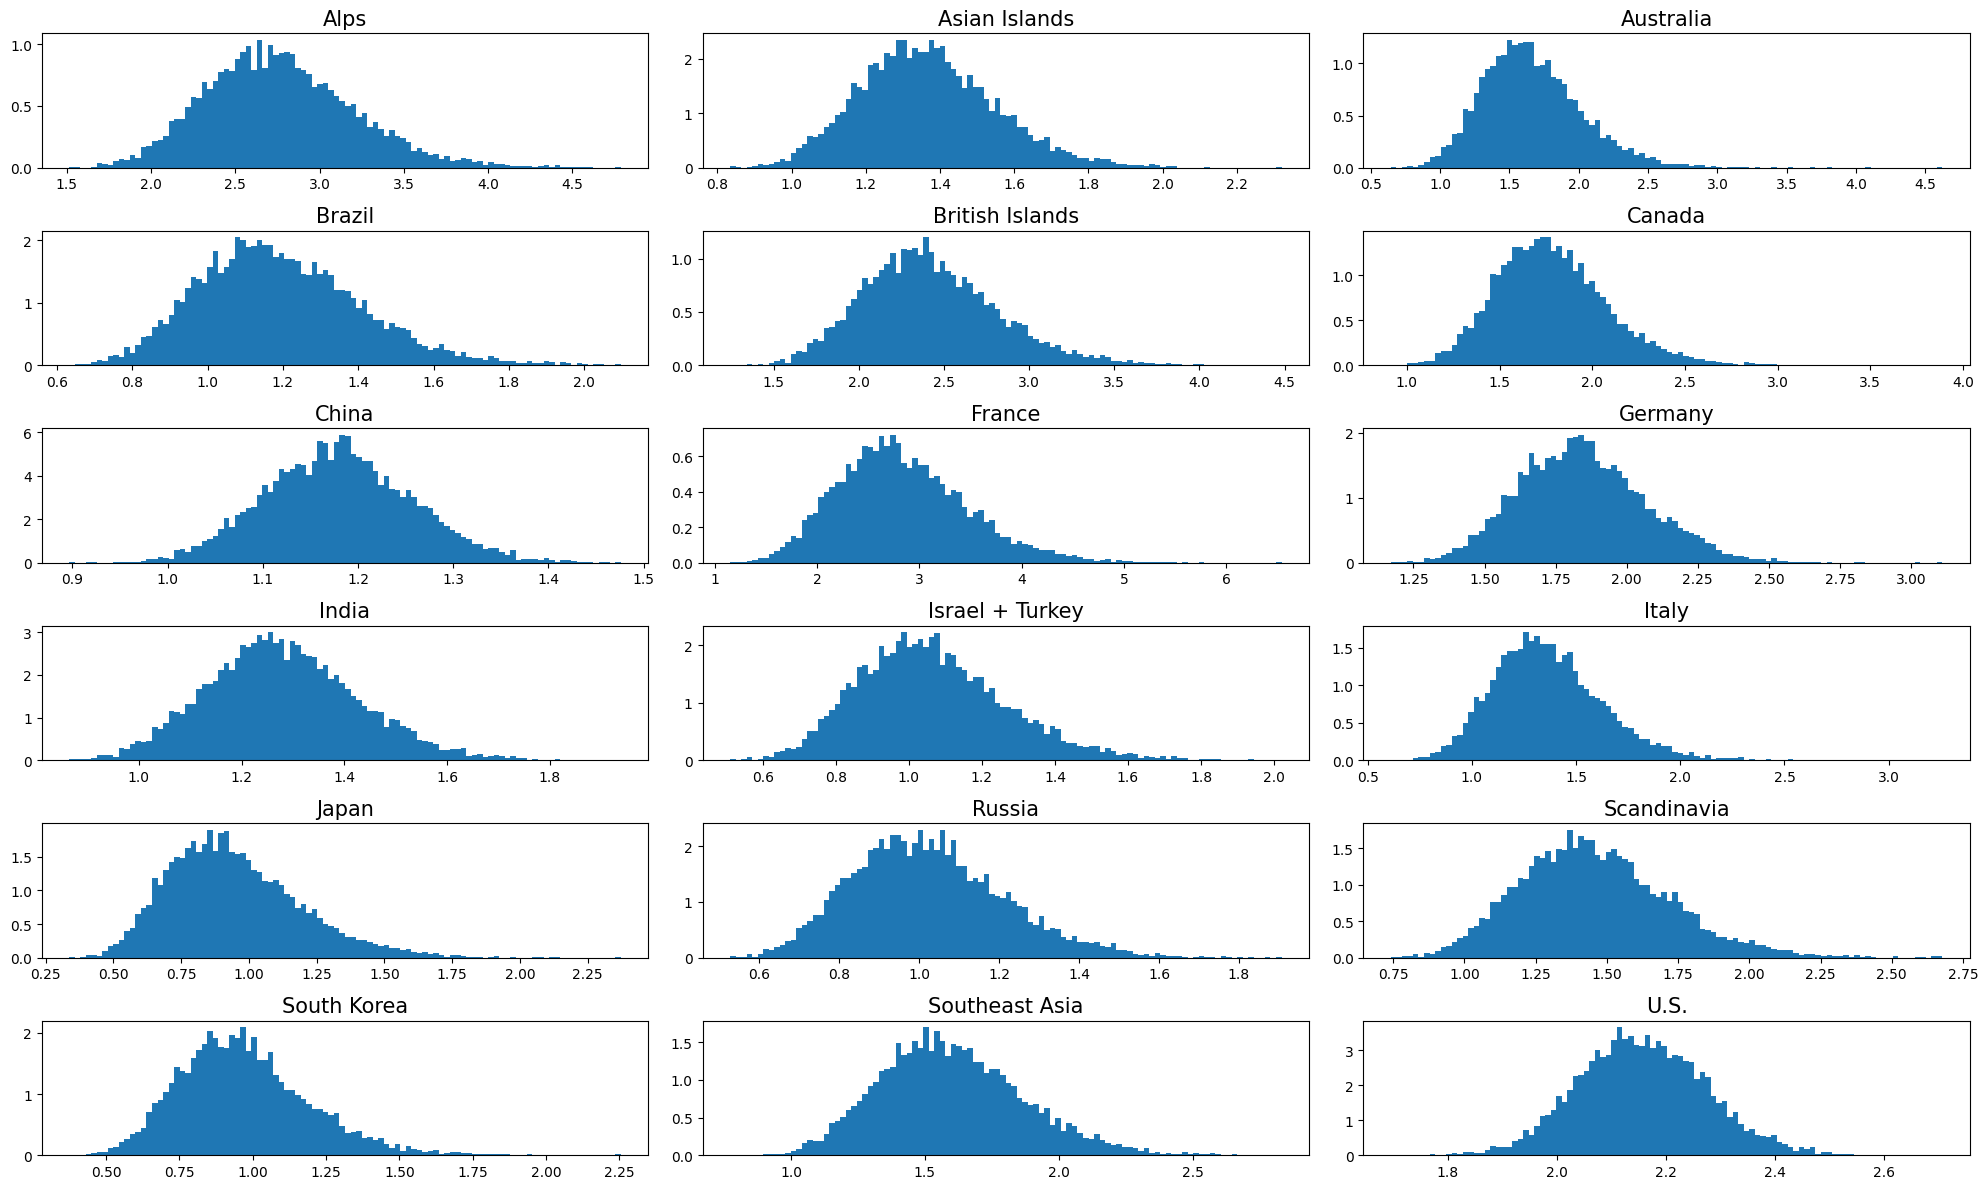

In [ ]:
genpareto_coef_df = scale_coefficient_df.xs('GeneralisedPareto', level='model_type').T
sub_regions = genpareto_coef_df.columns
fig, ax = plt.subplots(6, 3, figsize=(20, 12))
for i in range(6):
    for j in range(3):
        ax[i, j].hist(genpareto_coef_df[sub_regions[i*3+j]], bins=100, density=True)
        ax[i, j].set_title(sub_regions[i*3+j], fontsize=15)
        #ax[i, j].set_xlim(0, 1.0)
plt.tight_layout()
plt.show()

In [ ]:
path = "../../Stored_Results/bayesian_cross_sectional_regularised/shape_coefficient_df.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        shape_coefficient_df = dill.load(f)
else:
    shape_coefficients = {}
    for group in groups:
        print(f"Calculating for {group}")
        for model_type in ['Weibull', 'GeneralisedPareto']:
            model = train_or_retrieve_regularised_cross_sectional_model(panel_df=df, group=group, model_type=model_type, retrain_if_saved=False)
            post_pred_df = model.posterior_predictive()
            post_pred = post_pred_df['gamma']
            shape_coefficients[(group, model_type)] = post_pred.dropna()
    shape_coefficient_df = pd.DataFrame(shape_coefficients).T
    shape_coefficient_df.index.names = ['group', 'model_type']
    with open(path, 'wb') as f:
        dill.dump(shape_coefficient_df, f)

In [ ]:
shape_coefficient_df.T

group           Alps                   Asian Islands                    \
model_type   Weibull GeneralisedPareto       Weibull GeneralisedPareto   
0           0.847480          0.233081      0.495070          0.384404   
1           0.903040          0.239462      0.485172          0.363355   
2           0.884109          0.249921      0.463745          0.377421   
3           0.911288          0.224263      0.475370          0.345610   
4           0.760316          0.276891      0.494014          0.412196   
...              ...               ...           ...               ...   
7995        0.825138          0.169610      0.445586          0.410819   
7996        0.851793          0.228716      0.484145          0.385302   
7997        0.826110          0.243561      0.500714          0.309098   
7998        0.912663          0.226764      0.556436          0.412078   
7999        0.870179          0.259332      0.523443          0.370149   

group      Australia                      Brazil                    \
model_type   Weibull GeneralisedPareto   Weibull GeneralisedPareto   
0           0.437503          0.675869  0.406544          0.514244   
1           0.441543          0.655960  0.410619          0.464325   
2           0.419231          0.722069  0.411165          0.586303   
3           0.367486          0.566417  0.403306          0.498134   
4           0.519524          0.580782  0.417544          0.476563   
...              ...               ...       ...               ...   
7995        0.438309          0.587447  0.365725          0.469367   
7996        0.389102          0.579681  0.365760          0.597501   
7997        0.414723          0.530079  0.378089          0.502158   
7998        0.488199          0.634256  0.377862          0.469321   
7999        0.469161          0.520097  0.377897          0.497255   

group      British Islands                    ...    Russia                    \
model_type         Weibull GeneralisedPareto  ...   Weibull GeneralisedPareto   
0                 0.591361          0.262822  ...  0.271259          0.789054   
1                 0.664374          0.311008  ...  0.324766          0.857919   
2                 0.669574          0.328513  ...  0.302357          0.826785   
3                 0.727586          0.344283  ...  0.313099          0.830111   
4                 0.669634          0.398845  ...  0.323938          0.801731   
...                    ...               ...  ...       ...               ...   
7995              0.702227          0.307373  ...  0.348353          0.773505   
7996              0.686429          0.294647  ...  0.324901          0.814335   
7997              0.593781          0.325293  ...  0.389179          0.778743   
7998              0.674032          0.291288  ...  0.327819          0.852693   
7999              0.687560          0.207905  ...  0.265355          0.887380   

group      Scandinavia                   South Korea                    \
model_type     Weibull GeneralisedPareto     Weibull GeneralisedPareto   
0             0.596636          0.548765    0.382230          0.664903   
1             0.543543          0.465371    0.403971          0.710226   
2             0.523886          0.620690    0.367221          0.675607   
3             0.435207          0.453123    0.385458          0.606499   
4             0.516022          0.470863    0.387242          0.611372   
...                ...               ...         ...               ...   
7995          0.559646          0.558016    0.480089          0.588606   
7996          0.552068          0.464551    0.386196          0.521364   
7997          0.563726          0.583531    0.335999          0.549211   
7998          0.618110          0.568553    0.317433          0.577651   
7999          0.460229          0.422765    0.425003          0.643744   

group      Southeast Asia                        U.S.                    
model_type        Weibull Generalis

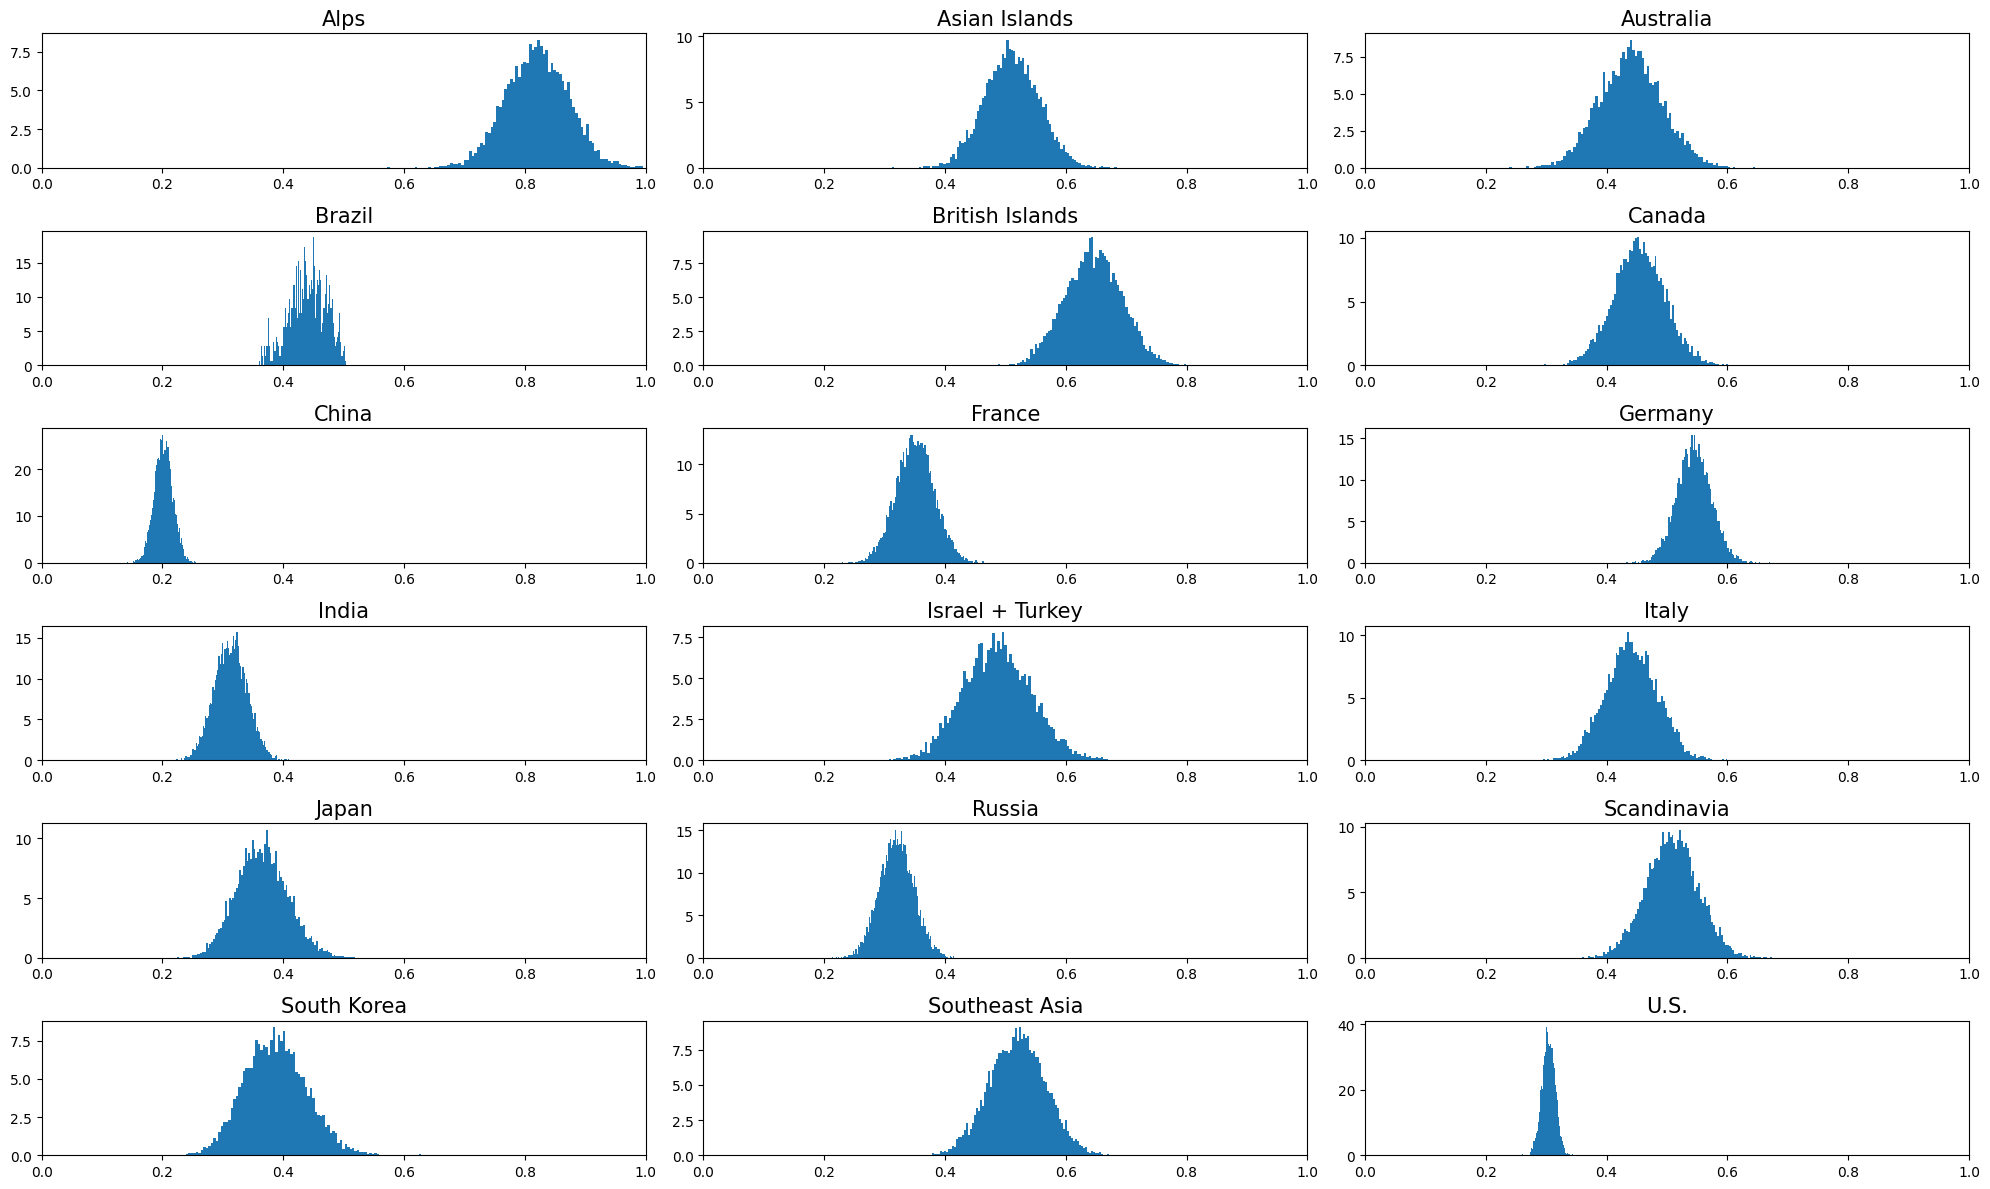

In [ ]:
weibull_coef_df = shape_coefficient_df.xs('Weibull', level='model_type').T
# drop rows where the brazil weibull coefficient is duplicated
sub_regions = weibull_coef_df.columns
fig, ax = plt.subplots(6, 3, figsize=(20, 12))
for i in range(6):
    for j in range(3):
        # special case for brazil
        if sub_regions[i*3+j] == 'Brazil':
            ax[i, j].hist(weibull_coef_df[sub_regions[i*3+j]].head(1000), bins=100, density=True)
            ax[i, j].set_title(sub_regions[i*3+j], fontsize=15)
            ax[i, j].set_xlim(0, 1.0)
        else:
            ax[i, j].hist(weibull_coef_df[sub_regions[i*3+j]], bins=100, density=True)
            ax[i, j].set_title(sub_regions[i*3+j], fontsize=15)
            ax[i, j].set_xlim(0, 1.0)
plt.tight_layout()
plt.show()


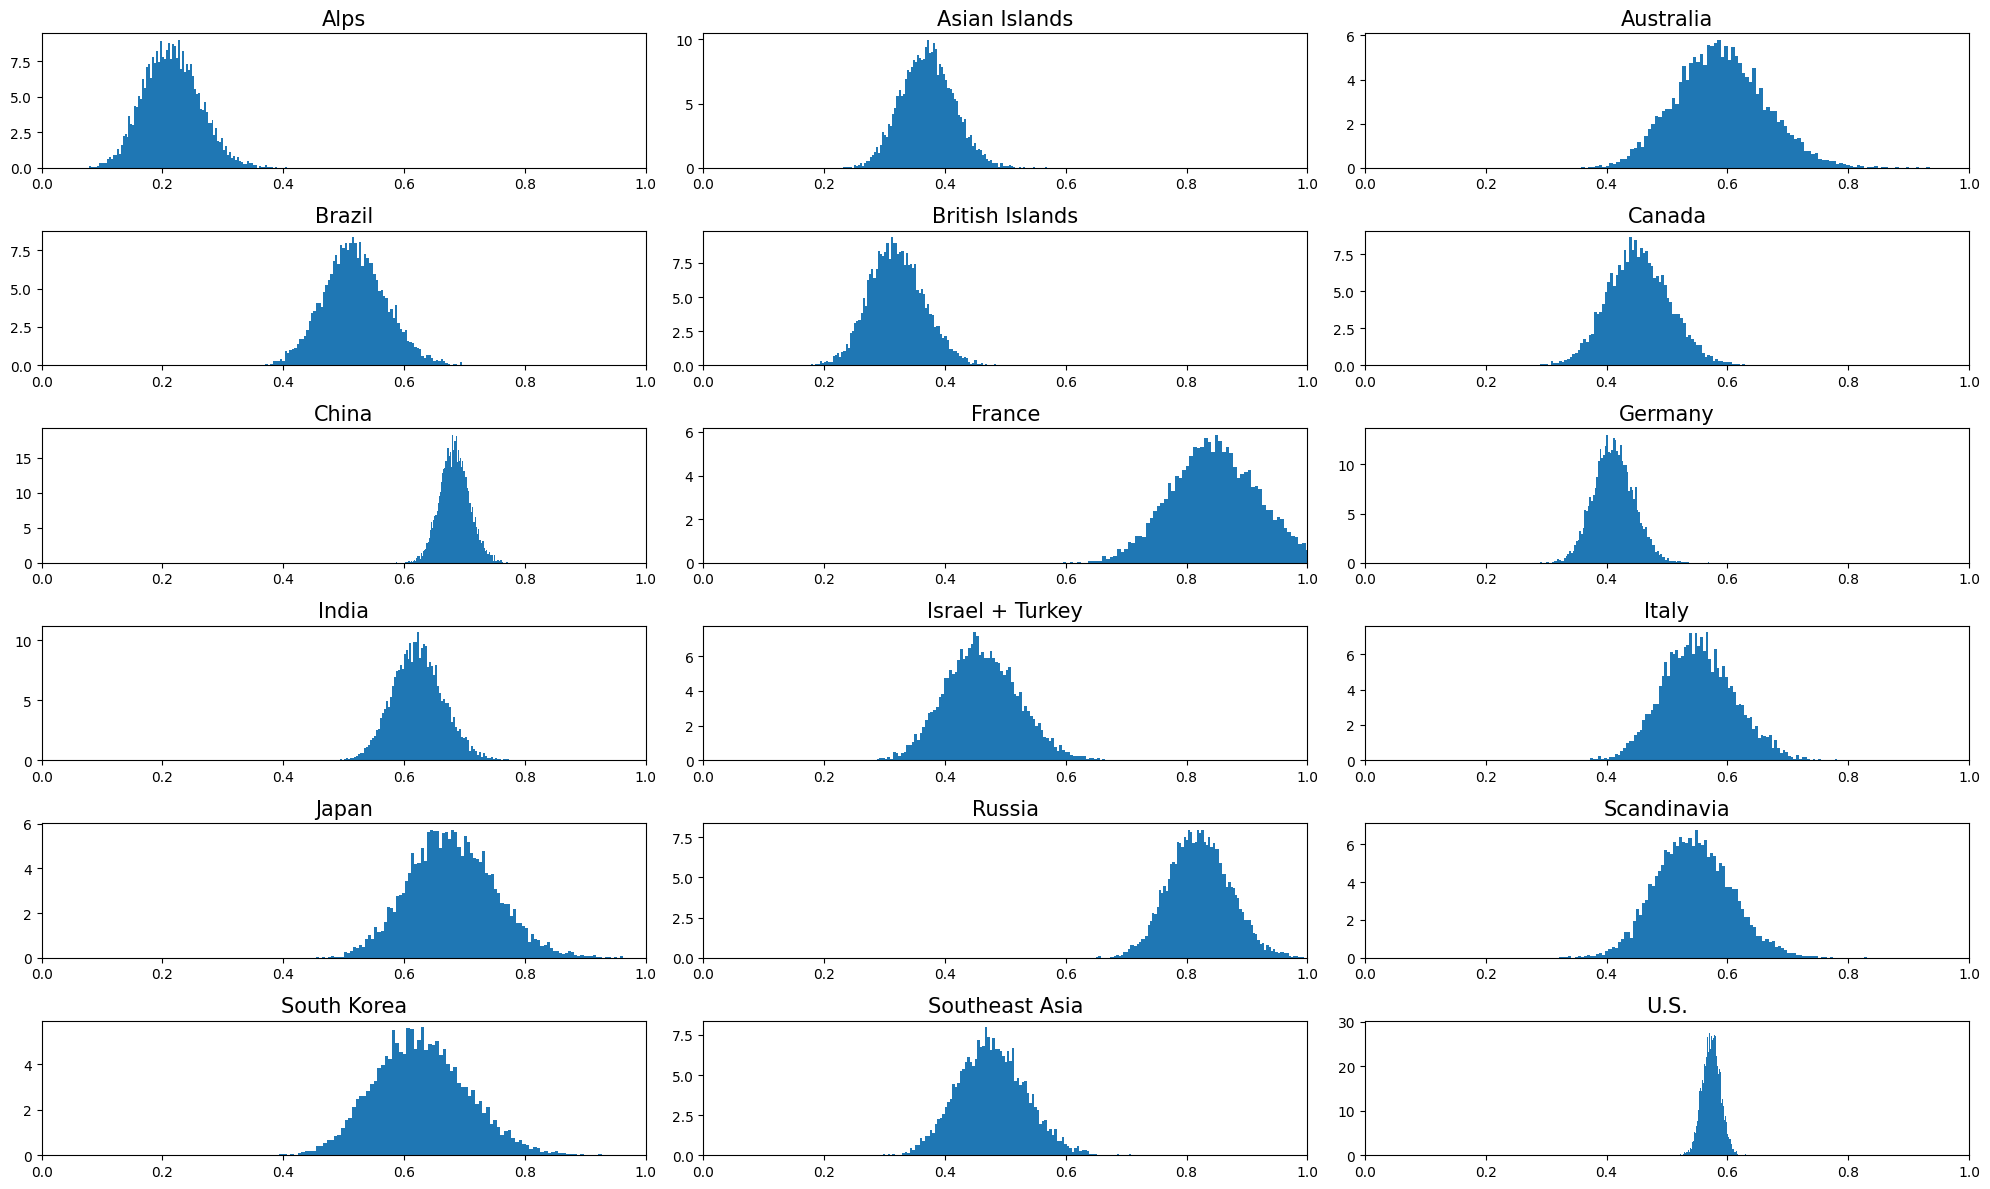

In [ ]:
genpareto_coef_df = shape_coefficient_df.xs('GeneralisedPareto', level='model_type').T
sub_regions = genpareto_coef_df.columns
fig, ax = plt.subplots(6, 3, figsize=(20, 12))
for i in range(6):
    for j in range(3):
        ax[i, j].hist(genpareto_coef_df[sub_regions[i*3+j]], bins=100, density=True)
        ax[i, j].set_title(sub_regions[i*3+j], fontsize=15)
        ax[i, j].set_xlim(0, 1.0)
plt.tight_layout()
plt.show()

In [ ]:
# for each column in the dataframe, do a Kolmogorov-Smirnov test to see if the coefficient is normally distributed
ks_coefficient_stats = {}
for column in weibull_coef_df.columns:
    standardised_data = (weibull_coef_df[column] - weibull_coef_df[column].mean()) / weibull_coef_df[column].std()
    ks_stat, ks_pval = scipy.stats.kstest(standardised_data, 'norm')
    ks_coefficient_stats[(column, 'Weibull')] = {'KS_stat': ks_stat, 'KS_pval': ks_pval}
for column in genpareto_coef_df.columns:
    standardised_data = (genpareto_coef_df[column] - genpareto_coef_df[column].mean()) / genpareto_coef_df[column].std()
    ks_stat, ks_pval = scipy.stats.kstest(standardised_data, 'norm')
    ks_coefficient_stats[(column, 'GeneralisedPareto')] = {'KS_stat': ks_stat, 'KS_pval': ks_pval}
ks_coefficient_stats_df = pd.DataFrame(ks_coefficient_stats).T
ks_coefficient_stats_df.index.names = ['region', 'model_type']

In [ ]:
# Do the same with the jarque-bera test
jb_coefficient_stats = {}
for column in weibull_coef_df.columns:
    jb_stat, jb_pval = scipy.stats.jarque_bera(weibull_coef_df[column])
    jb_coefficient_stats[(column, 'Weibull')] = {'JB_stat': jb_stat, 'JB_pval': jb_pval}
for column in genpareto_coef_df.columns:
    jb_stat, jb_pval = scipy.stats.jarque_bera(genpareto_coef_df[column])
    jb_coefficient_stats[(column, 'GeneralisedPareto')] = {'JB_stat': jb_stat, 'JB_pval': jb_pval}
jb_coefficient_stats_df = pd.DataFrame(jb_coefficient_stats).T
jb_coefficient_stats_df.index.names = ['region', 'model_type']

In [ ]:
ks_coefficient_stats_df.round(2)

,,KS_stat,KS_pval
region,model_type,,
Alps,Weibull,0.01,0.83
Asian Islands,Weibull,0.01,0.85
Australia,Weibull,0.01,0.57
Brazil,Weibull,0.17,0.00
British Islands,Weibull,0.01,0.90
Canada,Weibull,0.01,0.79
China,Weibull,0.01,0.42
France,Weibull,0.01,0.81
Germany,Weibull,0.01,0.91


In [ ]:
jb_coefficient_stats_df.round(2)

,,JB_stat,JB_pval
region,model_type,,
Alps,Weibull,2.50,0.29
Asian Islands,Weibull,1.60,0.45
Australia,Weibull,4.73,0.09
Brazil,Weibull,243.17,0.00
British Islands,Weibull,7.05,0.03
Canada,Weibull,0.88,0.65
China,Weibull,1.21,0.55
France,Weibull,0.56,0.76
Germany,Weibull,4.69,0.10
